# Vectorized Neural Network

This neural network will be fully vectorized in its feedforward and backpropagation.

We will first only implement a simple 1-hidden layer neural network, and we will extend it.

## Load Data

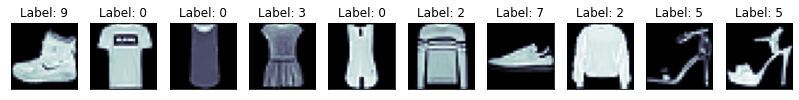

In [1]:
# Download Fashion MNIST Dataset
import gzip
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import xlogy

def fashion_mnist():
    """
    Download compressed Fashion MNIST data to local directory, and 
    unpack data into numpy arrays. 
    
    Return (train_images, train_labels, test_images, test_labels).

    Args:
        None

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    path = './' # Download data to current directory.
    os.makedirs(path, exist_ok=True) # Create path if it doesn't exist.

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = fashion_mnist()

# Plot examples from dataset.
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(train_images[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {train_labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])

In [2]:
import timeit as t

In [3]:
lr = 1e-4

# X is a (60000, 784) input where each row is a row vector sample 
X = train_images

# y is a (60000, 10) input where each row is a row vector label
y = train_labels

x_test, y_test = test_images, test_labels

print(f'Shape of X is {X.shape}')
print(f'Shape of y is {y.shape}')

# 0. INITIALIZE BATCH ARRAY

batch_size = 3

# neural network parameters

input_dim, hidden_dim, output_dim = X.shape[1], 150, y.shape[1]

print(input_dim, hidden_dim, output_dim)

Shape of X is (60000, 784)
Shape of y is (60000, 10)
784 150 10


## Implement Neural Network

In [4]:
# get all of our loss, output activation, and any other helper functions we need

def batch_crossentropy(y, y_hat):
    epsilon = 1e-4
    return -np.sum(y*np.log(y_hat + epsilon), axis=1)

def single_crossentropy(y, y_hat):
    epsilon = 1e-4
    return -np.sum(y*np.log(y_hat + epsilon))

def batch_softmax(x):
    li = []
    for i in range(x.shape[0]):
        exp_term = np.exp(x[i] - np.max(x))
        li.append(exp_term/np.sum(exp_term))
    return np.array(li)

def single_softmax(x):
    exp_term = np.exp(x - np.max(x))
    return exp_term/np.sum(exp_term)

def component_wise_tensor(A, B):
    tmp = []
    for i in range(len(A)):
        outer_product = np.outer(A[i], B[i])
        tmp.append(outer_product)
    C = np.array(tmp)
    return C


In [22]:
class simpleANN_v3:
    
    # artificial 1 hidden-layer neural network whose feedforward, backpropagation are all vectorized 
    
    def __init__(self, input_dim, hidden_dim, output_dim):
    
        # initialize weights and biases that will update
        # self.w1 = np.random.randn(input_dim, hidden_dim)
        # self.b1 = np.random.randn(hidden_dim)
        
        # self.w2 = np.random.randn(hidden_dim, output_dim)
        # self.b2 = np.random.randn(output_dim)

        self.w1 = None
        self.b1 = None

        self.w2 = None
        self.b2 = None

        # initialize a dummy variable for final weights and biases
        self.final_w1 = None
        self.final_b1 = None

        self.final_w2 = None
        self.final_b2 = None
        
        
    def feedforward(self, x, w1, w2, b1, b2, batch_size=3):
        # feedforward: perform the feeding of the input up until the output layer
        z1 = np.dot(x, w1) + b1

        # first activation (relu)
        # NOTE: normally, np.maximum(0, x) is the way to go, but since we are vectorizing, we must find a way to apply
        # relu across the whole vector
        a1 = z1

        a1[a1 < 0] = 0

        # derivative of first activation

        da_1_dz_1 = np.where(a1 > 0, 1, 0)

        # second preactivation layer

        z2 = np.dot(a1, w2) + b2
        
        return z1, a1, da_1_dz_1, z2
        
    def predict(self, x, batch_size=3):
        # predict: this is the output layer, where we will be calling the softmax function
        if batch_size > 1:
            return batch_softmax(x)
        else:
            return single_softmax(x)
    
    def loss(self, y, y_hat, batch_size=3):
        # loss: computes the cross-entropy loss 
        if batch_size > 1:
            return batch_crossentropy(y, y_hat)
        else:
            return single_crossentropy(y, y_hat)
        
    def backpropagate(self, x, y, y_hat, a1, da_1_dz_1, batch_size=3):
        # backpropagate: takes in x, y, y_hat, and the 2nd and 3rd outputs from feedforward
        dl_dz2 = y_hat - y

        # TRICKY PART: since we now have every sample's vectors, we must do
        # a component-wise outer product of each vector
        # EACH "ROW" (axis 0) OF ARRAY CORRESPONDS TO A dl/dw2 for each input/label pair
        
        dl_dw2 = np.mean(component_wise_tensor(dl_dz2, a1), axis=0).T

        # THEN TAKE THE MEAN ACROSS AXIS 0 TO GET THE UPDATED WEIGHTS, and then tranpose

        dl_dz1 = np.dot(dl_dz2, self.w2.T) * da_1_dz_1

        # elementwise tensor product, then take the mean across the axis and transpose

        dl_dw1 = np.mean(component_wise_tensor(dl_dz1, x), axis=0).T

        # get gradient of biases

        dl_db2, dl_db1 = dl_dz2, dl_dz1
        
        return dl_dw1, dl_dw2, dl_db1, dl_db2
    
    def gradient_descent(self, grad_w1, grad_w2, grad_b1, grad_b2, lr=1e-4, batch_size=3):
        # gradient_descent: performs optimization of weights and biases
        # NOTE: changes the weights/biases in place, so returns nothing
        
        # eta is just a constant
        eta = lr/batch_size
        
        # actual GD steps
        self.w1, self.w2, self.b1, self.b2 = self.w1 - (eta * grad_w1), self.w2 - (eta * grad_w2), self.b1 - (eta * grad_b1), self.b2 - (eta * grad_b2)
        
        # initialize final weights and biases (for validation testing really)
        # for the parameters with dimensions including batch size, average out over the entire batch
        self.final_w1, self.final_w2, self.final_b1, self.final_b2 = self.w1, self.w2, np.mean(self.b1, axis=0), np.mean(self.b2, axis=0)
        return

    def fit(self, x, y, max_epochs=10, lr=1e-4, x_val=None, y_val=None, batch_size=3):
        # fit: performs training loop by calling feedforward, predict, loss, backpropagation, and gradient_descent
        # NOTE: this training is done in batches, validation inferencing at the end of each epoch is optional
        
        # array holding all batches of data
        batch_arr = [(x[k:k+batch_size], y[k:k+batch_size]) for k in range(0, x.shape[0], batch_size)]
        num_batches = len(batch_arr)
        
        # count total train time
        total_train_time = 0
        
        # compile a history for metrics so we can plot performance later
        history, li_trainloss, li_trainacc = dict(), [], []

        if x_val is not None and y_val is not None:
            num_vals, li_valloss, li_valacc = 0, [], []
        
        # training loop
        for epoch in range(max_epochs):
            epoch_correct_classes = 0
            # initialize total loss in epoch
            epoch_loss = 0
            # call timer to roughly time how long each epoch took
            start = t.default_timer()
            for x_batch, y_batch in batch_arr:
                # 1. feedforward
                # obtains the parameters we need to plug into predict and backpropagate

                # initialize the batch training weights and biases if they are not initialized yet
                # otherwise, just continue with our methods
                if self.w1 is None and self.w2 is None and self.b1 is None and self.b2 is None:
                    self.w1 = np.random.randn(input_dim, hidden_dim)
                    self.b1 = np.random.randn(batch_size, hidden_dim)
                    
                    self.w2 = np.random.randn(hidden_dim, output_dim)
                    self.b2 = np.random.randn(batch_size, output_dim)
                else:
                    pass

                # run feedforward on batch weights
                _, a1, da1_dz1, z2 = self.feedforward(x_batch, self.w1, self.w2, self.b1, self.b2)
                
                # 2. predict
                # gets the y_hat
                
                y_hat = self.predict(z2, batch_size)
                
                # 3. get loss
                # gets an array of losses of size (batch_size,), corresponding to each input-label in the batch
                
                batch_loss = self.loss(y_batch, y_hat, batch_size)
                
                # 4. backpropagate
                # obtains the gradients used in the gradient descent
                
                grad_w1, grad_w2, grad_b1, grad_b2 = self.backpropagate(x_batch, y_batch, y_hat, a1, da1_dz1)
                
                # 5. batch gradient descent
                # changes weights and biases inplace
                
                self.gradient_descent(grad_w1, grad_w2, grad_b1, grad_b2, lr)
                
                # 6. average the loss across this batch
                epoch_loss += np.mean(batch_loss)
                
                # 7. compare classes of y_hat to y_batch
                batch_predicted_classes = np.argmax(y_hat, axis=1)
                
                epoch_correct_classes += (batch_predicted_classes == np.argmax(y_batch, axis=1)).sum()
            
            # implement the validation testing (not batching here, evaluate one-by-one)
            if x_val is not None and y_val is not None:
                epoch_loss_val = 0
                epoch_val_classes_correct = 0
                val_arr = [(x_, y_) for x_, y_ in zip(x_val, y_val)]
                num_vals = len(val_arr)
                for x_, y_ in val_arr:
                    # run feedforward on batch weights
                    _, _, _, z2_val = self.feedforward(x_, self.final_w1, self.final_w2, self.final_b1, self.final_b2)
                    
                    # 2. predict
                    # gets the y_hat
                    
                    # use single softmax here (set batch_size = 1)
                    y_hat = self.predict(z2_val, batch_size=1)
                    
                    # 3. get loss
                    # gets an array of losses of size (batch_size,), corresponding to each input-label in the batch
                    
                    val_loss = self.loss(y_, y_hat, batch_size=1)
                    
                    # 6. average the loss across this batch
                    epoch_loss_val += val_loss
                    
                    # 7. compare classes of y_hat to y_
                    val_predicted_classes = np.argmax(y_hat, axis=0)
                    
                    epoch_val_classes_correct += (val_predicted_classes == np.argmax(y_, axis=0)).sum()                    


            # stop timer after one epoch
            stop = t.default_timer()
            # get loss per sample per epoch (average across all batches)
            epoch_loss /= num_batches
            epoch_loss_val /= num_vals
            # put loss per epoch into history
            li_trainloss.append(epoch_loss)
            # put accuracy per epoch into history
            li_trainacc.append(epoch_correct_classes/x.shape[0])

            # append validation metrics if it is given
            if x_val is not None and y_val is not None:
                li_valloss.append(epoch_loss_val)
                li_valacc.append(epoch_val_classes_correct/num_vals)

            # get total time elapsed during training
            epoch_time = stop - start
            # get total time elapsed overall
            total_train_time += epoch_time
            
            # print output for training metrics
            print(f'Epoch {epoch + 1} : Loss {epoch_loss} : Training Accuracy {epoch_correct_classes/x.shape[0]*100:.4f}% : Training Runtime {epoch_time} Seconds\nValidation Loss {epoch_loss_val} Validation Accuracy {epoch_val_classes_correct/x_val.shape[0] * 100:.4f}%')
        
        # print output for total train time
        print(f'Total Training Runtime {total_train_time} Seconds')
        
        # put losses into history
        history['train loss'] = li_trainloss
        history['train accuracy'] = li_trainacc

        if x_val is not None and y_val is not None:
            history['val loss'] = li_valloss
            history['val accuracy'] = li_valacc

        return history

## Initialize Model and Evaluate Performance

In [6]:
# initialize ANN

ANN1_v3 = simpleANN_v3(input_dim, hidden_dim, output_dim)

print(f'Our Simple Neural Network has {input_dim} input nodes, {hidden_dim} hidden nodes, and {output_dim} output nodes.')


Our Simple Neural Network has 784 input nodes, 150 hidden nodes, and 10 output nodes.


In [7]:
# fit

history1_v3 = ANN1_v3.fit(X, y, max_epochs = 10, lr = 1e-3, x_val=x_test, y_val=y_test, batch_size=3)

Epoch 1 : Loss 3.194770904184704 : Training Accuracy 61.3750% : Training Runtime 102.35881210000001 Seconds
Validation Loss 2.2308067901330886 Validation Accuracy 72.0400%
Epoch 2 : Loss 2.0617616029681276 : Training Accuracy 73.2467% : Training Runtime 135.80381769999997 Seconds
Validation Loss 1.9152146499901417 Validation Accuracy 74.6100%
Epoch 3 : Loss 1.8229627722542845 : Training Accuracy 74.9950% : Training Runtime 121.18866790000001 Seconds
Validation Loss 1.7427869113115482 Validation Accuracy 75.8200%
Epoch 4 : Loss 1.6572099032154721 : Training Accuracy 75.8583% : Training Runtime 152.75298229999999 Seconds
Validation Loss 1.5981790030106098 Validation Accuracy 76.5800%
Epoch 5 : Loss 1.5179579472554936 : Training Accuracy 76.3400% : Training Runtime 170.60867929999995 Seconds
Validation Loss 1.4793738830804348 Validation Accuracy 76.3000%
Epoch 6 : Loss 1.3895013807269347 : Training Accuracy 76.6617% : Training Runtime 125.65272870000001 Seconds
Validation Loss 1.371237467

In [8]:
# what keys the dictionary has

history1_v3.keys()

dict_keys(['train loss', 'train accuracy', 'val loss', 'val accuracy'])

In [9]:
import matplotlib.pyplot as plt

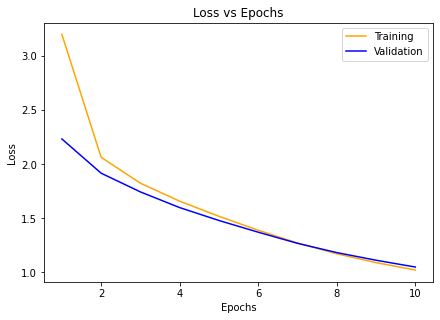

In [11]:
fig1 = plt.figure(figsize=(6,4))
axis1 = fig1.add_axes([0.1,0.1,0.9,0.9])

axis1.set_title('Loss vs Epochs')
axis1.plot(range(1,11), history1_v3['train loss'], color='orange',label='Training')
axis1.plot(range(1,11), history1_v3['val loss'], color='blue',label='Validation')
axis1.set_ylabel('Loss')
axis1.set_xlabel('Epochs')
axis1.legend(loc=0)

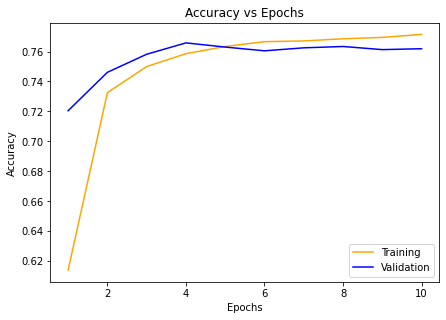

In [12]:
fig2 = plt.figure(figsize=(6,4))
axis2 = fig2.add_axes([0.1,0.1,0.9,0.9])

axis2.set_title('Accuracy vs Epochs')
axis2.plot(range(1,11), history1_v3['train accuracy'], color='orange',label='Training')
axis2.plot(range(1,11), history1_v3['val accuracy'], color='blue',label='Validation')
axis2.set_ylabel('Accuracy')
axis2.set_xlabel('Epochs')
axis2.legend(loc=0)

## More Trials!

In [13]:
# fit
ANN2_v3 = simpleANN_v3(input_dim, hidden_dim, output_dim)

history2_v3 = ANN2_v3.fit(X, y, max_epochs = 10, lr = 1e-2, x_val=x_test, y_val=y_test, batch_size=10)

Epoch 1 : Loss 2.3330002068526223 : Training Accuracy 70.4900% : Training Runtime 103.58141639999985 Seconds
Validation Loss 1.7153468433790626 Validation Accuracy 75.7900%
Epoch 2 : Loss 1.5085125896365326 : Training Accuracy 76.3233% : Training Runtime 104.64856259999988 Seconds
Validation Loss 1.3064405176095677 Validation Accuracy 77.1500%
Epoch 3 : Loss 1.1538592341750566 : Training Accuracy 77.0517% : Training Runtime 95.87221910000017 Seconds
Validation Loss 1.0358811310269478 Validation Accuracy 77.7700%
Epoch 4 : Loss 0.9527641112614604 : Training Accuracy 77.8600% : Training Runtime 99.16896789999987 Seconds
Validation Loss 0.9175539509559867 Validation Accuracy 78.2800%
Epoch 5 : Loss 0.8427877193647011 : Training Accuracy 78.3733% : Training Runtime 100.04722659999993 Seconds
Validation Loss 0.8360594813248748 Validation Accuracy 79.1100%
Epoch 6 : Loss 0.7719692648446259 : Training Accuracy 78.8083% : Training Runtime 98.5811086000001 Seconds
Validation Loss 0.782053322974

In [14]:
# fit
ANN3_v3 = simpleANN_v3(input_dim, 200, output_dim)

history3_v3 = ANN3_v3.fit(X, y, max_epochs = 15, lr = 1e-2, x_val=x_test, y_val=y_test, batch_size=10)

Epoch 1 : Loss 2.380857392265956 : Training Accuracy 69.6800% : Training Runtime 99.4162765000001 Seconds
Validation Loss 1.7465957385006947 Validation Accuracy 75.6100%
Epoch 2 : Loss 1.5563537877518563 : Training Accuracy 76.2967% : Training Runtime 86.74370429999999 Seconds
Validation Loss 1.3677686498941226 Validation Accuracy 76.7100%
Epoch 3 : Loss 1.2401029553052343 : Training Accuracy 77.2367% : Training Runtime 59.02394120000008 Seconds
Validation Loss 1.1575061118033072 Validation Accuracy 76.7800%
Epoch 4 : Loss 1.0190547585128082 : Training Accuracy 77.7233% : Training Runtime 58.12657300000001 Seconds
Validation Loss 0.9874464710177228 Validation Accuracy 77.4300%
Epoch 5 : Loss 0.8776667035315499 : Training Accuracy 78.3250% : Training Runtime 57.229053999999905 Seconds
Validation Loss 0.8696299834239045 Validation Accuracy 77.9200%
Epoch 6 : Loss 0.7901779185427266 : Training Accuracy 78.8367% : Training Runtime 56.85441320000018 Seconds
Validation Loss 0.802960762214998

In [15]:
# fit
ANN4_v3 = simpleANN_v3(input_dim, 300, output_dim)

history4_v3 = ANN4_v3.fit(X, y, max_epochs = 15, lr = 5e-2, x_val=x_test, y_val=y_test, batch_size=20)

Epoch 1 : Loss 1.868878194654773 : Training Accuracy 72.4067% : Training Runtime 60.577386599999954 Seconds
Validation Loss 1.1311507370948497 Validation Accuracy 76.0000%
Epoch 2 : Loss 0.9510869494278771 : Training Accuracy 76.0933% : Training Runtime 62.3856237 Seconds
Validation Loss 0.8444206328250495 Validation Accuracy 77.1900%
Epoch 3 : Loss 0.7698912378013876 : Training Accuracy 77.4067% : Training Runtime 60.24411989999999 Seconds
Validation Loss 0.752529747151832 Validation Accuracy 78.2100%
Epoch 4 : Loss 0.6886164308785877 : Training Accuracy 78.2900% : Training Runtime 60.22769730000027 Seconds
Validation Loss 0.7022795847413238 Validation Accuracy 78.6800%
Epoch 5 : Loss 0.6394547639839213 : Training Accuracy 79.0767% : Training Runtime 57.291423600000144 Seconds
Validation Loss 0.6710399013770441 Validation Accuracy 79.1800%
Epoch 6 : Loss 0.6058229698778177 : Training Accuracy 79.7083% : Training Runtime 57.541818299999704 Seconds
Validation Loss 0.6475860061004981 Val

In [16]:
# fit
ANN5_v3 = simpleANN_v3(input_dim, 400, output_dim)

history5_v3 = ANN5_v3.fit(X, y, max_epochs = 20, lr = 1e-1, x_val=x_test, y_val=y_test, batch_size=40)

Epoch 1 : Loss 1.8322274185485312 : Training Accuracy 72.4133% : Training Runtime 57.37133530000028 Seconds
Validation Loss 1.09147500116665 Validation Accuracy 75.2100%
Epoch 2 : Loss 0.9198359117178817 : Training Accuracy 76.3267% : Training Runtime 56.55649690000064 Seconds
Validation Loss 0.8647098743511417 Validation Accuracy 77.0600%
Epoch 3 : Loss 0.744725379809275 : Training Accuracy 77.8900% : Training Runtime 56.9014502 Seconds
Validation Loss 0.7731166980777151 Validation Accuracy 78.0400%
Epoch 4 : Loss 0.6609077261595186 : Training Accuracy 79.0550% : Training Runtime 62.57803530000001 Seconds
Validation Loss 0.717560810940773 Validation Accuracy 78.7300%
Epoch 5 : Loss 0.6112650889209554 : Training Accuracy 79.7883% : Training Runtime 62.581817299999784 Seconds
Validation Loss 0.6816854785578685 Validation Accuracy 79.3100%
Epoch 6 : Loss 0.5773010307126958 : Training Accuracy 80.4550% : Training Runtime 58.56767789999958 Seconds
Validation Loss 0.657014286491189 Validati

In [17]:
# fit
ANN6_v3 = simpleANN_v3(input_dim, 800, output_dim)

history6_v3 = ANN6_v3.fit(X, y, max_epochs = 20, lr = 1e-1, x_val=x_test, y_val=y_test, batch_size=50)

Epoch 1 : Loss 2.4406767717357916 : Training Accuracy 68.6983% : Training Runtime 65.32301300000017 Seconds
Validation Loss 1.7464516911478098 Validation Accuracy 74.2100%
Epoch 2 : Loss 1.474278108371816 : Training Accuracy 75.4767% : Training Runtime 59.363783599999806 Seconds
Validation Loss 1.3153917857366797 Validation Accuracy 74.8200%
Epoch 3 : Loss 1.106900988792222 : Training Accuracy 76.2933% : Training Runtime 60.115346300000056 Seconds
Validation Loss 1.0601456278445227 Validation Accuracy 75.9000%
Epoch 4 : Loss 0.9146400646230645 : Training Accuracy 77.0383% : Training Runtime 58.03780800000004 Seconds
Validation Loss 0.941933901372784 Validation Accuracy 76.4000%
Epoch 5 : Loss 0.8107340185221891 : Training Accuracy 77.9917% : Training Runtime 68.40494060000037 Seconds
Validation Loss 0.870899214095872 Validation Accuracy 76.9400%
Epoch 6 : Loss 0.7454631638019618 : Training Accuracy 78.7300% : Training Runtime 74.04092010000022 Seconds
Validation Loss 0.8203395371065959

In [24]:
# fit
ANN7_v3 = simpleANN_v3(input_dim, 800, output_dim)

history7_v3 = ANN7_v3.fit(X, y, max_epochs = 20, lr = 1e-1, x_val=x_test, y_val=y_test, batch_size=50)

Epoch 1 : Loss 1.9715451753698199 : Training Accuracy 71.3017% : Training Runtime 100.90587640000012 Seconds
Validation Loss 1.2267896763836323 Validation Accuracy 74.5400%
Epoch 2 : Loss 1.027826979679292 : Training Accuracy 75.1467% : Training Runtime 79.89434750000146 Seconds
Validation Loss 0.9000073855301381 Validation Accuracy 75.7800%
Epoch 3 : Loss 0.8049177231285287 : Training Accuracy 76.5767% : Training Runtime 57.15185989999918 Seconds
Validation Loss 0.7914043089471067 Validation Accuracy 76.8100%
Epoch 4 : Loss 0.7112080511744271 : Training Accuracy 77.5950% : Training Runtime 57.28040019999935 Seconds
Validation Loss 0.7348083057101273 Validation Accuracy 77.5200%
Epoch 5 : Loss 0.6561931162825507 : Training Accuracy 78.4667% : Training Runtime 58.13321240000005 Seconds
Validation Loss 0.699573743710965 Validation Accuracy 78.2000%
Epoch 6 : Loss 0.6191568029242673 : Training Accuracy 79.1067% : Training Runtime 57.022065699999075 Seconds
Validation Loss 0.67499042537574

## Conclusion

Here, we implemented a 1-hidden layer neural network, with a fully-vectorized training loop (i.e. with **mini-batch gradient descent**). We see here that the loss and accuracy metrics indicate that our barebones neural network is, indeed, learning. In fact, we even see where the validation metrics and the training metrics intersect one another. After multiple combinations of hand-tuned learning rates and mini batch sizes, we see that our network learned the most for a configuration of:

- Learning Rate - 0.1
- Hidden Layer - 400 nodes
- Mini-batch size - 40 samples

The final validation accuracy for this configuration was 81.93%, which is solid given the simplicity of our neural network. This was not even an architecture suitable for image recognition, yet it generalized properly to achieve almost 82% accuracy on images of clothing. Furthermore, we know that this neural network is being evaluated correctly because the loss curves and accuracy curves for the training and validation evaluation intersects at roughly the same point in time. This shows that the learning of our model directly translates to better inferencing results.